In [ ]:
import os
import cv2
import uuid

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from collections import defaultdict
from collections import Counter

In [42]:
path = 'dataset.csv'
data_df = pd.read_csv(path)
data_df.shape

(112120, 2)

In [43]:
# Drop rows with 'No Finding' label
data_df['has_no_finding'] = data_df['labels'].apply(lambda x: 'No Finding' in [label.strip() for label in x.split('|')])
filtered_df = data_df[~data_df['has_no_finding']].copy()
filtered_df = filtered_df.drop(columns=['has_no_finding'])

filtered_df.shape

(51759, 2)

In [44]:
filtered_df.drop_duplicates(subset=['path'], inplace=True)
filtered_df.shape

(51759, 2)

In [45]:
# filtered_df.to_csv('filtered_data.csv', index=False)

In [46]:
# labels_split = filtered_df['labels'].str.split('|')

# all_labels = sorted(set(label for sublist in labels_split for label in sublist))

# for label in all_labels:
#     filtered_df[label] = labels_split.apply(lambda x: int(label in x))

# filtered_df.sample(5)

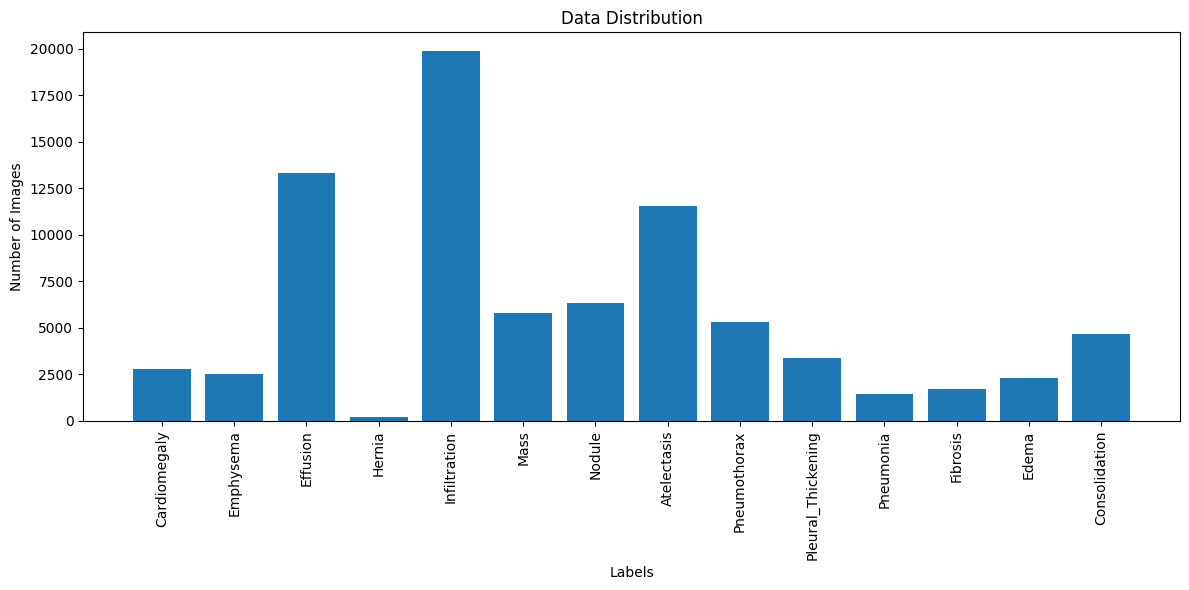

In [47]:
def plot_distribution(df, title='Plot', is_save_fig=False, file_name='fig.png'):
    label_to_images = defaultdict(list)
        
    label_counts = defaultdict(int)
    for index, row in df.iterrows():
        labels = row['labels'].split('|')
        image_path = row['path']
        for label in labels:
            label = label.strip()
            label_counts[label] += 1
            label_to_images[label].append(image_path)

    plt.figure(figsize=(12, 6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel('Labels')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    if is_save_fig:
        plt.savefig(file_name)
    plt.show()

plot_distribution(filtered_df, title='Data Distribution', is_save_fig=True, file_name='data_distribution.png')

In [48]:
filtered_df['labels_list'] = filtered_df['labels'].str.split('|')
all_labels = filtered_df['labels_list'].explode()
label_counts = Counter(all_labels)

rare_labels = [label for label, count in label_counts.items() if count < 5000]
print(rare_labels)

['Cardiomegaly', 'Emphysema', 'Hernia', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']


In [49]:
def has_rare_label(label_list, rare_labels):
    return any(label in rare_labels for label in label_list)

rare_df = filtered_df[filtered_df['labels_list'].apply(lambda x: has_rare_label(x, rare_labels))]
rare_df.shape

(16953, 3)

In [52]:
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(filtered_df['labels_list'])

def stratified_split(X, Y, test_size=0.2, val_size=0.3, random_state=42):
    mskf = MultilabelStratifiedKFold(n_splits=int(1 / test_size), shuffle=True, random_state=random_state)
    for train_idx, temp_idx in mskf.split(X, Y):
        break
    X_train, Y_train = X.iloc[train_idx], Y[train_idx]
    X_temp, Y_temp = X.iloc[temp_idx], Y[temp_idx]

    mskf_val = MultilabelStratifiedKFold(n_splits=int(1 / val_size), shuffle=True, random_state=random_state)
    for val_idx, test_idx in mskf_val.split(X_temp, Y_temp):
        break
    X_val, X_test = X_temp.iloc[val_idx], X_temp.iloc[test_idx]

    return X_train.reset_index(drop=True), X_val.reset_index(drop=True), X_test.reset_index(drop=True)

train_df, val_df, test_df = stratified_split(filtered_df, Y)

val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

print(f"Train: {len(train_df)} - Val: {len(val_df)} - Test: {len(test_df)}")

Train: 41445 - Val: 6862 - Test: 3452


In [ ]:
def get_augment_times(label):
    count = label_counts[label]
    if count < 500:
        return 10 
    elif count < 1000:
        return 5
    elif count < 2000:
        return 3
    elif count < 5000:
        return 2
    else:
        return 0

augmented_folder = 'augmented_images'
os.makedirs(augmented_folder, exist_ok=True)

augmenter = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5)
])

augmented_paths = []
augmented_labels = []

for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img = cv2.imread(row['path'])
    if img is None:
        continue
    
    labels = row['labels_list']
    
    times = min([get_augment_times(label) for label in labels])
    if times == 0:
        continue
    for j in range(times):
        aug = augmenter(image=img)['image']
        new_path = os.path.join(augmented_folder, f"{uuid.uuid4().hex}.jpg")
        cv2.imwrite(new_path, aug)
        augmented_paths.append(new_path)
        augmented_labels.append(row['labels'])

aug_df = pd.DataFrame({
    'path': augmented_paths,
    'labels': augmented_labels
})
aug_df['labels_list'] = aug_df['labels'].str.split('|')

augmented_df = pd.concat([train_df, aug_df], ignore_index=True)

d:\Project\python\DiagnosticSystemForChestX-rayImageClassification\.venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|██████████| 41445/41445 [14:43<00:00, 46.94it/s]


In [54]:
augmented_df.shape

(53879, 3)

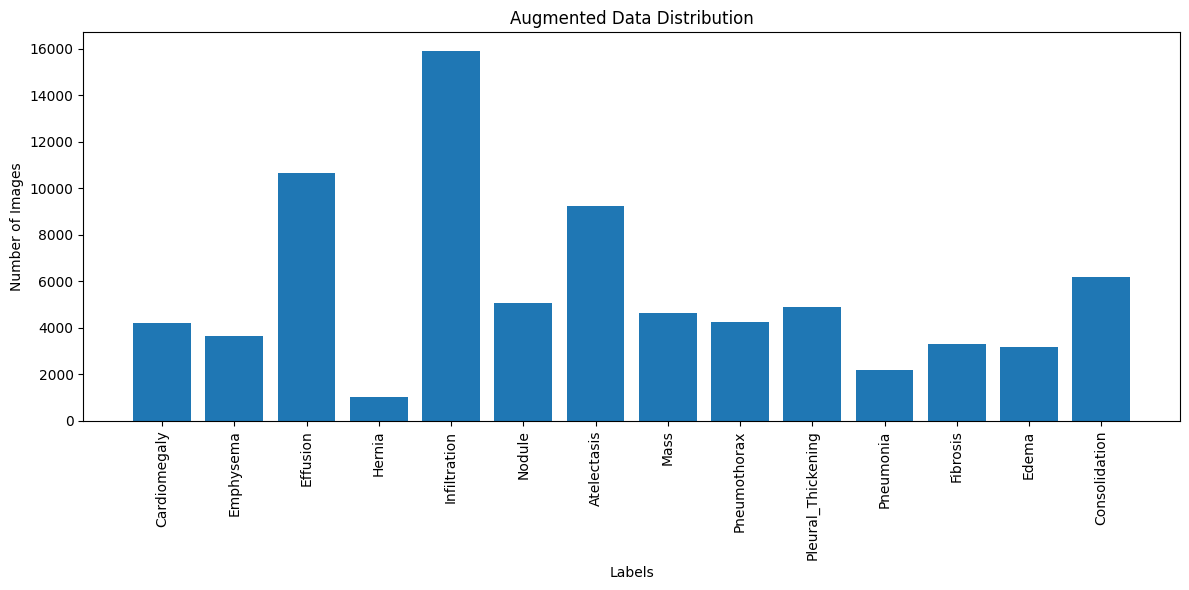

In [55]:
plot_distribution(augmented_df, title='Augmented Data Distribution', is_save_fig=True, file_name='augmented_distribution.png')

In [56]:
# Calculate class weights
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(augmented_df['labels_list'])
label_names = mlb.classes_

N = Y.shape[0]
K = Y.shape[1]
label_counts = np.sum(Y, axis=0)
class_weights = N / (K * label_counts)

class_weights_df = pd.DataFrame({
    'label': label_names,
    'class_weight': class_weights
})
class_weights_df.to_csv('class_weights.csv', index=False)

for label, count, weight in zip(label_names, label_counts, class_weights):
    print(f"{label:<20} | Count: {int(count):<6} | Class Weight: {weight:.4f}")

Atelectasis          | Count: 9247   | Class Weight: 0.4162
Cardiomegaly         | Count: 4199   | Class Weight: 0.9165
Consolidation        | Count: 6175   | Class Weight: 0.6232
Edema                | Count: 3170   | Class Weight: 1.2140
Effusion             | Count: 10654  | Class Weight: 0.3612
Emphysema            | Count: 3637   | Class Weight: 1.0582
Fibrosis             | Count: 3324   | Class Weight: 1.1578
Hernia               | Count: 1020   | Class Weight: 3.7730
Infiltration         | Count: 15915  | Class Weight: 0.2418
Mass                 | Count: 4626   | Class Weight: 0.8319
Nodule               | Count: 5065   | Class Weight: 0.7598
Pleural_Thickening   | Count: 4890   | Class Weight: 0.7870
Pneumonia            | Count: 2184   | Class Weight: 1.7621
Pneumothorax         | Count: 4241   | Class Weight: 0.9075


In [57]:
# Calculate sample weights
sample_weights = []
for row in Y:
    weights = class_weights[row == 1]
    sample_weights.append(np.mean(weights) if len(weights) > 0 else 1.0)

augmented_df['sample_weight'] = sample_weights
augmented_df.sample(5)

,path,labels,labels_list,sample_weight
18776,.\chestXray14\images_006\images\00013625_058.png,Infiltration,[Infiltration],0.241816
47690,augmented_images\6cf88b8fae6d46cdb1de69f9170d0...,Fibrosis,[Fibrosis],1.157792
2839,.\chestXray14\images_002\images\00002120_002.png,Atelectasis,[Atelectasis],0.416189
31857,.\chestXray14\images_010\images\00021420_001.png,Infiltration|Nodule,"[Infiltration, Nodule]",0.500819
28792,.\chestXray14\images_009\images\00019551_004.png,Cardiomegaly|Infiltration,"[Cardiomegaly, Infiltration]",0.579172


In [58]:
augmented_df.to_csv('augmented_data.csv', index=False)

In [ ]:
sample = augmented_df.sample(5).iloc[0]
img = cv2.imread(sample['path'])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Labels: {sample['labels']}\nSample Weight: {sample['sample_weight']:.4f}")
plt.axis('off')
plt.show()

In [ ]:
img = cv2.imread(sample['path'])
img_np = np.array(img)